## Dataset loading using braindecode

In [1]:
import braindecode

<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [2]:
import torch
from braindecode.models import EEGNetv4, EEGConformer, ATCNet, EEGITNet, EEGInception
from braindecode.datasets import MOABBDataset

In [3]:
raw_dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=None)

Preprocess dataset using braindecode API

In [4]:
from braindecode.preprocessing import create_windows_from_events
from braindecode.preprocessing import exponential_moving_standardize, preprocess, Preprocessor

In [ ]:
low_freq = 4
high_freq = 38
resample_freq = 250

# preprocess data using "braindecode.preprocessor"
# only use eeg(stim channels must be removed)
preprocessors = [Preprocessor('pick', picks=['eeg'])]

# if pick_channels:
#     preprocessors.append(Preprocessor('pick', picks=pick_channels))
# preprocessors.append(Preprocessor(lambda data: multiply(data, 1e6)))
if low_freq or high_freq:
    preprocessors.append(Preprocessor('filter', l_freq=low_freq, h_freq=high_freq))
if resample_freq:
    preprocessors.append(Preprocessor('resample', sfreq=resample_freq))
preprocessors.append(Preprocessor(exponential_moving_standardize, factor_new=1e-3))
preprocess(raw_dataset, preprocessors)

Window Split (for each trail start and end)

In [7]:
start_offset = -0.5
stop_offset = 0

sfreq = raw_dataset.datasets[0].raw.info['sfreq']
#assert all([ds.raw.info['sfreq'] == sfreq for ds in raw_dataset.datasets])
trial_start_offset_samples = int(start_offset * sfreq)
trial_stop_offset_samples = int(stop_offset * sfreq)

windows_dataset = create_windows_from_events(
    raw_dataset,
    trial_start_offset_samples,
    trial_stop_offset_samples,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [8]:
import pandas as pd
df = pd.DataFrame(windows_dataset.get_metadata())
df.to_csv('windows_dataset.csv')
windows_dataset.get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,session,run
0,0,125,1250,3,1,0train,0
1,0,2128,3253,0,1,0train,0
2,0,4046,5171,2,1,0train,0
3,0,5998,7123,1,1,0train,0
4,0,8006,9131,1,1,0train,0
...,...,...,...,...,...,...,...
43,0,86625,87750,0,9,1test,5
44,0,88531,89656,3,9,1test,5
45,0,90459,91584,0,9,1test,5
46,0,92573,93698,1,9,1test,5


In [13]:
import numpy as np

In [14]:
meta_windows = windows_dataset.get_metadata()
np.unique(meta_windows['session'], return_counts = True)

(array(['0train', '1test'], dtype=object), array([2592, 2592], dtype=int64))

Get additional dataset details and set model configuration

In [9]:
n_channels = raw_dataset[0][0].shape[0]
n_times = windows_dataset[0][0].shape[1]
n_classes = 4 # number of classes in the dataset used

n_epochs = 6
lr = 0.001
batch_size = 64

# variables to save the model
save = 'store_true'
save_dir = 'models/'
strategy = 'within-subject' # 'within-subject' or 'cross-subject'
model_name = 'EEGNet' # 'EEGNet', 'EEGConformer', 'ATCNet', 'EEGITNet', 'EEGInception'
verbose = 2

Split data  into test and train based on window subset

In [10]:
from skorch.helper import SliceDataset
from skorch.callbacks import LRScheduler, TrainEndCheckpoint
from skorch import NeuralNetClassifier

cuda = torch.cuda.is_available()


In [17]:
X = []
y = []
for i in range(len(windows_dataset)):
    x, target, window_ind = windows_dataset[i]
    # print(f"Shape of window {i}: {x.shape}, Label: {target}")
    X.append(x)
    y.append(target)

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [ ]:
X = np.array(X)
enc = OneHotEncoder()
y = enc.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [38]:
X_train.shape

(3628, 22, 1125)

In [41]:
y_train.shape

(3628, 4)

In [44]:
np.unique(np.argmax(y_test, axis=1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([404, 359, 390, 403], dtype=int64))

In [45]:
np.unique(np.argmax(y_train, axis=1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([892, 937, 906, 893], dtype=int64))

In [46]:
from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit

In [48]:
cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 16)

In [49]:
def CV_train(model, X, X_test, cnn = False, convlstm = False, batch_size = 32, n_epochs = 50, y_out = y_train, y_out_test = y_test):
    acc = []
    f1 = []
    prec = []
    recall = []
    results = {}
    best_model = model
    prev_metric = 0
    best_hist = []
    for train_idx, val_idx in cv.split(y_out):

        nn = [] 

        label_train, _ = y_out[train_idx], y_out[val_idx]
        y_train, y_val = y_out[train_idx], y_out[val_idx] 

        X_train = X[train_idx] 
        X_val = X[val_idx] 
        
        if cnn:
            X_train = np.expand_dims(X_train,-1)
        elif convlstm:
            X_train = np.expand_dims(np.expand_dims(X_train, -1),-1)

        nn = model

        history = nn.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = batch_size, epochs = n_epochs)

        y_pred = nn.predict(X_val)
        pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

        acc_score = accuracy_score(y_val.argmax(axis=1), pred.argmax(axis=1))
        acc.append(acc_score)
        f1_val = (f1_score(y_val.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
        f1.append(f1_val)
        prec.append(precision_score(y_val.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
        recall.append(recall_score(y_val.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
        if f1_val > prev_metric: 
            prev_metric = f1_val
            best_model = model
            best_hist = history
    
    test_pred = best_model.predict(X_test)
    pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
    acc.append(accuracy_score(y_out_test.argmax(axis=1), pred.argmax(axis=1)))
    f1.append(f1_score(y_out_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
    prec.append(precision_score(y_out_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    recall.append(recall_score(y_out_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    
    results['Accuracy'] = acc
    results['F1'] = f1
    results['Precision'] = prec
    results['Recall'] = recall

    plt.plot(best_hist.history['loss'], label='Training Loss')
    plt.plot(best_hist.history['val_loss'], label='Validation Loss', color = 'b')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.plot(best_hist.history['accuracy'], label='Training Accuracy')
    plt.plot(best_hist.history['val_accuracy'], label='Validation Accuracy', color = 'b')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return best_model, results

In [ ]:
import mne 
import numpy as np
import pandas as pd
import torch
import os
import braindecode
import matplotlib.pyplot as plt
from braindecode.models import EEGNetv4, EEGConformer, ATCNet, EEGITNet, EEGInception
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
from braindecode.preprocessing import exponential_moving_standardize, preprocess, Preprocessor

import scipy.io
import pywt
from mne.decoding import CSP # Common Spatial Pattern Filtering
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape, ConvLSTM1D, Conv2D
from keras import regularizers
from sklearn import preprocessing
from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit

In [107]:
def build_mlp_classifier(num_layers = 1, lr = 0.01):
    classifier = Sequential()
    classifier.add(Flatten())
    #First Layer
    classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', 
                         kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
    classifier.add(Dropout(0.4))
    # Intermediate Layers
    for itr in range(num_layers):
        classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', 
                             kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
        classifier.add(Dropout(0.4))   
    # Last Layer
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = keras.optimizers.Adam(lr=lr) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

In [108]:
mlp = build_mlp_classifier(5, 0.0001)
mlp, mlp_results = CV_train(mlp, X_train, X_test, n_epochs=100)

Epoch 1/100
91/91 [==============================] - 4s 30ms/step - loss: 42.5500 - accuracy: 0.2409 - val_loss: 31.7529 - val_accuracy: 0.2713
Epoch 2/100
91/91 [==============================] - 2s 25ms/step - loss: 24.3984 - accuracy: 0.2553 - val_loss: 18.0797 - val_accuracy: 0.2713
Epoch 3/100
91/91 [==============================] - 2s 25ms/step - loss: 13.8364 - accuracy: 0.2584 - val_loss: 10.2247 - val_accuracy: 0.2713
Epoch 4/100
91/91 [==============================] - 2s 26ms/step - loss: 7.8544 - accuracy: 0.2550 - val_loss: 5.8632 - val_accuracy: 0.2713
Epoch 5/100
91/91 [==============================] - 2s 25ms/step - loss: 4.5940 - accuracy: 0.2550 - val_loss: 3.5442 - val_accuracy: 0.2713
Epoch 6/100
91/91 [==============================] - 2s 25ms/step - loss: 2.8973 - accuracy: 0.2540 - val_loss: 2.3716 - val_accuracy: 0.2713
Epoch 7/100
91/91 [==============================] - 2s 25ms/step - loss: 2.0596 - accuracy: 0.2550 - val_loss: 1.8108 - val_accuracy: 0.2713


KeyboardInterrupt: 

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [55]:
def build_eegnet_classifier(nb_classes=4, Chans = 22, Samples = 1125, 
             dropoutRate = 0.3, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    classifier = Model(inputs=input1, outputs=softmax)
    classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [57]:
X_train.shape

(3628, 22, 1125)

Epoch 1/30
91/91 [==============================] - 14s 146ms/step - loss: 1.3870 - accuracy: 0.2605 - val_loss: 1.3831 - val_accuracy: 0.2893
Epoch 2/30
91/91 [==============================] - 13s 143ms/step - loss: 1.3469 - accuracy: 0.3284 - val_loss: 1.3626 - val_accuracy: 0.3168
Epoch 3/30
91/91 [==============================] - 13s 147ms/step - loss: 1.3221 - accuracy: 0.3436 - val_loss: 1.3303 - val_accuracy: 0.3430
Epoch 4/30
91/91 [==============================] - 13s 146ms/step - loss: 1.3087 - accuracy: 0.3711 - val_loss: 1.3119 - val_accuracy: 0.3416
Epoch 5/30
91/91 [==============================] - 14s 159ms/step - loss: 1.2921 - accuracy: 0.3832 - val_loss: 1.2791 - val_accuracy: 0.3926
Epoch 6/30
91/91 [==============================] - 14s 152ms/step - loss: 1.2720 - accuracy: 0.3963 - val_loss: 1.2780 - val_accuracy: 0.3719
Epoch 7/30
91/91 [==============================] - 14s 150ms/step - loss: 1.2580 - accuracy: 0.4001 - val_loss: 1.2509 - val_accuracy: 0.3953

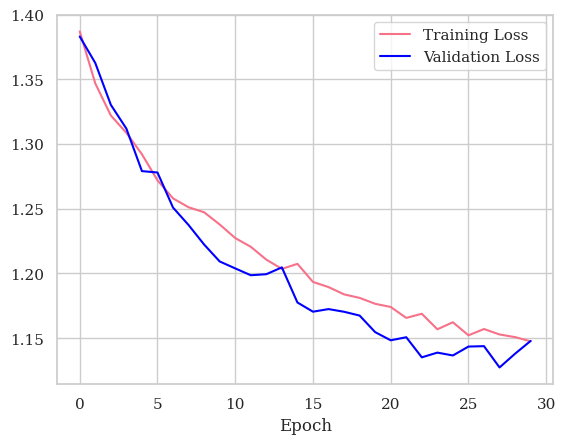

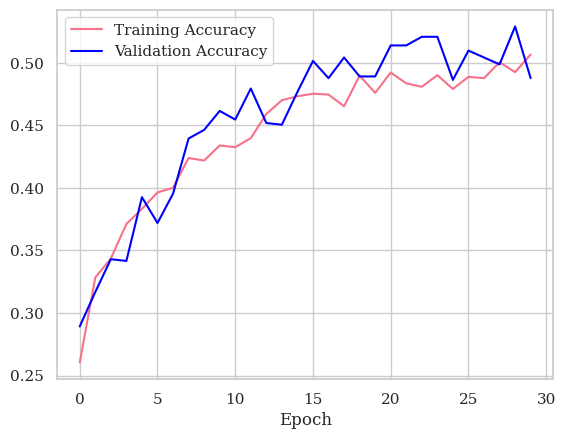

In [59]:
eegnet = build_eegnet_classifier()
eegnet, eegnet_results = CV_train(eegnet, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=30)

Epoch 1/30
91/91 [==============================] - 14s 150ms/step - loss: 1.1424 - accuracy: 0.5017 - val_loss: 1.1414 - val_accuracy: 0.5000
Epoch 2/30
91/91 [==============================] - 13s 145ms/step - loss: 1.1433 - accuracy: 0.4997 - val_loss: 1.1576 - val_accuracy: 0.5262
Epoch 3/30
91/91 [==============================] - 13s 145ms/step - loss: 1.1537 - accuracy: 0.4931 - val_loss: 1.1310 - val_accuracy: 0.5193
Epoch 4/30
91/91 [==============================] - 13s 145ms/step - loss: 1.1433 - accuracy: 0.4986 - val_loss: 1.1316 - val_accuracy: 0.5220
Epoch 5/30
91/91 [==============================] - 14s 150ms/step - loss: 1.1451 - accuracy: 0.4955 - val_loss: 1.1310 - val_accuracy: 0.5413
Epoch 6/30
91/91 [==============================] - 13s 147ms/step - loss: 1.1326 - accuracy: 0.5034 - val_loss: 1.1356 - val_accuracy: 0.5193
Epoch 7/30
91/91 [==============================] - 13s 147ms/step - loss: 1.1426 - accuracy: 0.5034 - val_loss: 1.1161 - val_accuracy: 0.5606

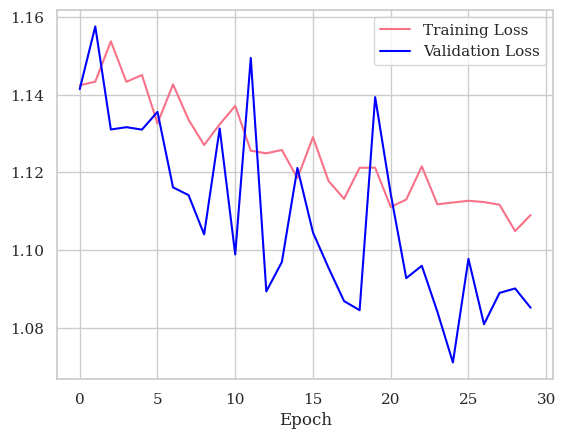

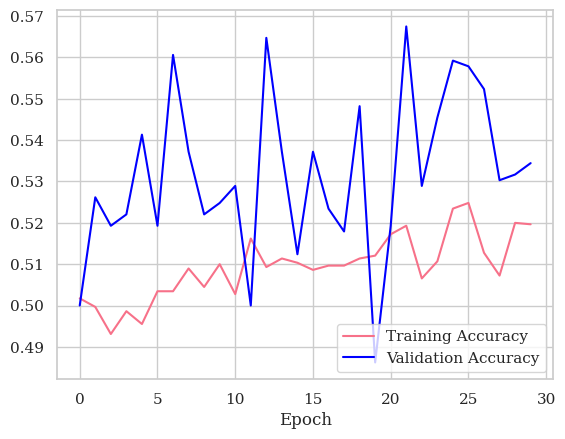

In [60]:
eegnet, eegnet_results = CV_train(eegnet, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=30)

In [61]:
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000)) 


In [62]:
def build_shallow_conv_net(nb_classes=4, Chans = 22, Samples = 1125, dropoutRate = 0.5):
    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                        input_shape=(Chans, Samples, 1),
                        kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    return Model(inputs=input_main, outputs=softmax)

Epoch 1/30


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 14s 144ms/step - loss: 3.6889 - accuracy: 0.2750 - val_loss: 1.8149 - val_accuracy: 0.3099
Epoch 2/30
91/91 [==============================] - 12s 133ms/step - loss: 2.8321 - accuracy: 0.3191 - val_loss: 1.4864 - val_accuracy: 0.3843
Epoch 3/30
91/91 [==============================] - 12s 133ms/step - loss: 2.6340 - accuracy: 0.3477 - val_loss: 2.7126 - val_accuracy: 0.3264
Epoch 4/30
91/91 [==============================] - 12s 135ms/step - loss: 2.2633 - accuracy: 0.3635 - val_loss: 2.3568 - val_accuracy: 0.3760
Epoch 5/30
91/91 [==============================] - 12s 133ms/step - loss: 1.9840 - accuracy: 0.3942 - val_loss: 2.1703 - val_accuracy: 0.4008
Epoch 6/30
91/91 [==============================] - 12s 134ms/step - loss: 2.1681 - accuracy: 0.4035 - val_loss: 1.8131 - val_accuracy: 0.3554
Epoch 7/30
91/91 [==============================] - 12s 135ms/step - loss: 1.9677 - accuracy: 0.4063 - val_loss: 1.4946 - val_accuracy: 0.4146
Epoch 8/30

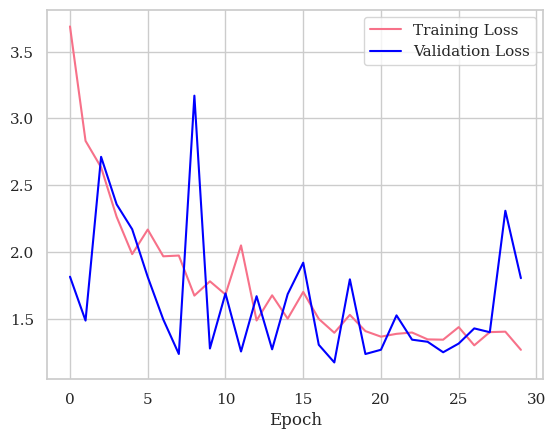

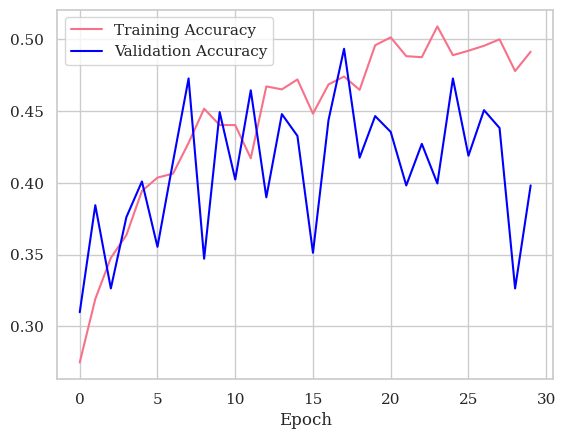

In [63]:
scn = build_shallow_conv_net()
scn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
scn, scn_results = CV_train(scn, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=30)

In [64]:
def build_deep_conv_net(nb_classes=4, Chans = 22, Samples = 1125, dropoutRate = 0.5):
    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

Epoch 1/30


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 14s 144ms/step - loss: 1.8121 - accuracy: 0.2536 - val_loss: 1.5610 - val_accuracy: 0.2466
Epoch 2/30
91/91 [==============================] - 12s 135ms/step - loss: 1.6318 - accuracy: 0.2615 - val_loss: 1.5753 - val_accuracy: 0.2810
Epoch 3/30
91/91 [==============================] - 12s 135ms/step - loss: 1.6615 - accuracy: 0.2784 - val_loss: 1.4319 - val_accuracy: 0.2645
Epoch 4/30
91/91 [==============================] - 12s 136ms/step - loss: 1.5314 - accuracy: 0.2905 - val_loss: 1.4140 - val_accuracy: 0.2948
Epoch 5/30
91/91 [==============================] - 12s 136ms/step - loss: 1.5097 - accuracy: 0.2815 - val_loss: 1.5110 - val_accuracy: 0.2824
Epoch 6/30
91/91 [==============================] - 13s 138ms/step - loss: 1.5066 - accuracy: 0.2895 - val_loss: 1.3871 - val_accuracy: 0.2782
Epoch 7/30
91/91 [==============================] - 13s 138ms/step - loss: 1.4813 - accuracy: 0.3218 - val_loss: 1.3664 - val_accuracy: 0.3085
Epoch 8/30

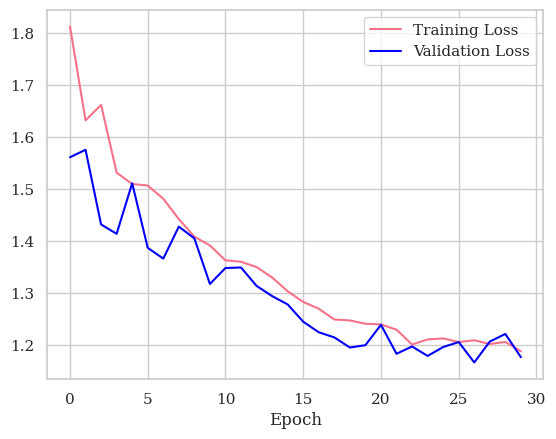

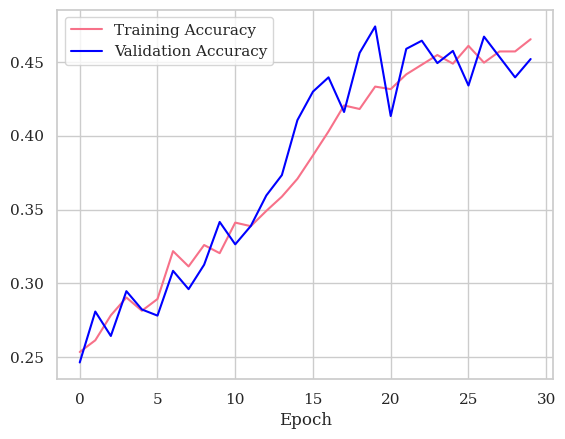

In [65]:
dcn = build_deep_conv_net()
dcn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
dcn, dcn_results = CV_train(dcn, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=30)

In [93]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
eegv4 = NeuralNetClassifier(module=EEGNetv4,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__kernel_length=32,
        module__drop_prob=0.5,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )

eegv4.fit(X_train, y_train, epochs=100)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4701  0.0010  1.2483
      2        1.3987  0.0009  1.0973
      3        1.3801  0.0007  1.1003
      4        1.3776  0.0003  1.0937
      5        1.3641  0.0001  1.0853
      6        1.3664  0.0000  1.1093
      7        1.3578  0.0001  1.0877
      8        1.3594  0.0003  1.0793
      9        1.3432  0.0007  1.1032
     10        1.3361  0.0009  1.0789
     11        1.3178  0.0010  1.0935
     12        1.2992  0.0009  1.0708
     13        1.2878  0.0007  1.0647
     14        1.2715  0.0003  1.0232
     15        1.2615  0.0001  1.0812
     16        1.2512  0.0000  1.0504
     17        1.2590  0.0001  1.0183
     18        1.2572  0.0003  1.1163
     19        1.2581  0.0007  1.0167
     20        1.2612  0.0009  1.0298
     21        1.2435  0.0010  1.0627
     22        1.2330  0.0009  1.0134
     23        1.2286  0.0007  1.0708
     24        1.2219  0.0003  1.0734
     25     

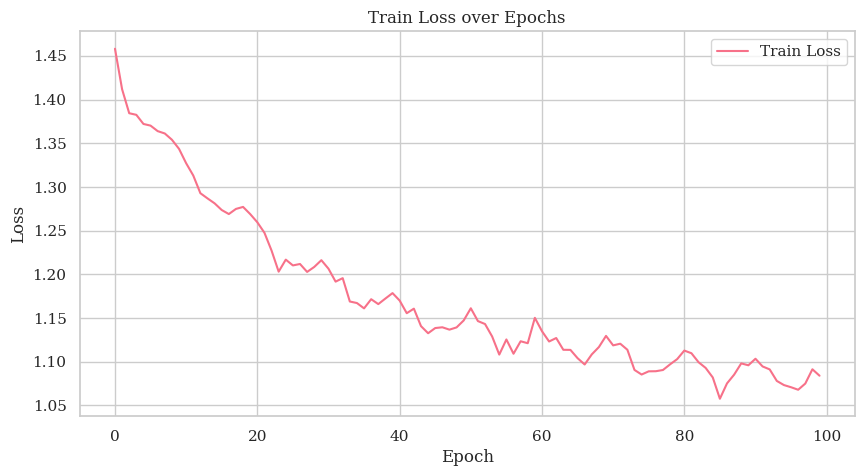

In [104]:
print("Train Accuracy: ", eegv4.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", eegv4.score(X_test, np.argmax(y_test, axis=1)))

train_loss = eegv4.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
from braindecode.models import *

In [97]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
atcnet = NeuralNetClassifier(module=ATCNet,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        # module__kernel_length=32,
        # module__drop_prob=0.5,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )
# clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
atcnet.fit(X_train, y_train, epochs=100)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4325  0.0010  5.6700
      2        1.3953  0.0009  5.7054
      3        1.3514  0.0007  5.5286
      4        1.3241  0.0003  5.4077
      5        1.3195  0.0001  5.4670
      6        1.3087  0.0000  5.3739
      7        1.3142  0.0001  5.5216
      8        1.3060  0.0003  5.5212
      9        1.2963  0.0007  5.5041
     10        1.2943  0.0009  5.4319
     11        1.2671  0.0010  5.3898
     12        1.2560  0.0009  5.4540
     13        1.2317  0.0007  5.4573
     14        1.2297  0.0003  5.4833
     15        1.2113  0.0001  5.5072
     16        1.1999  0.0000  5.4049
     17        1.2116  0.0001  5.4687
     18        1.2051  0.0003  5.4707
     19        1.2093  0.0007  5.4455
     20        1.2127  0.0009  5.3896
     21        1.1913  0.0010  5.7073
     22        1.1777  0.0009  5.5742
     23        1.1618  0.0007  5.5085
     24        1.1391  0.0003  5.3127
     25     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_============================================================================================================================================================
  Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Kernel Shape
  ATCNet (ATCNet)                                         [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                            [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                           [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─_ConvBlock (conv_block): 1-3                          [1, 1, 1125, 22]          [1, 32, 20, 1]            --                        --
  │    └─Conv2d (conv1): 2-1                              [1, 1, 11

In [99]:
import matplotlib.pyplot as plt

Train Accuracy:  0.8051267916207276
Test Accuracy:  0.5880462724935732


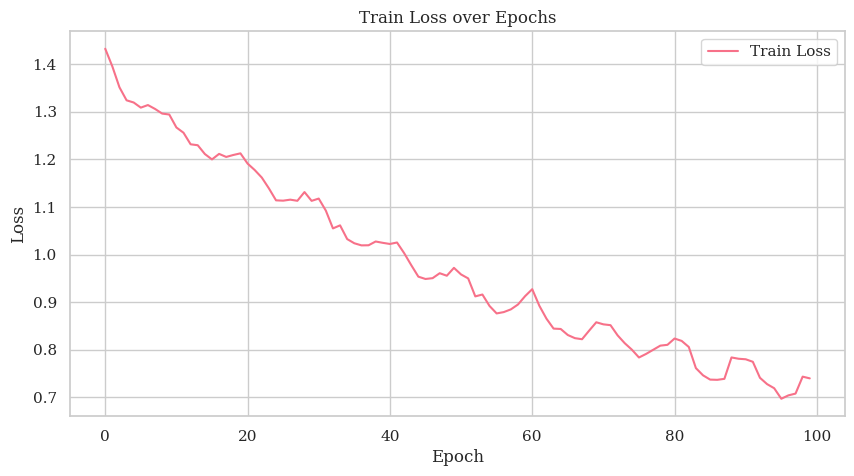

In [100]:
print("Train Accuracy: ", atcnet.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", atcnet.score(X_test, np.argmax(y_test, axis=1)))

train_loss = atcnet.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# subjects_windows_dataset = windows_dataset.split('subject')
# n_subjects = len(subjects_windows_dataset.items())
# avg_accuracy = 0

# # iterate over each subject (9 subjects)
# for subject, window_dataset in subjects_windows_dataset.items():
#         # evaluate the model by test accuracy for "Hold-Out" strategy
#         train_dataset = windows_dataset.split('session')['0train']
#         test_dataset = windows_dataset.split('session')['1test']

#         train_X = SliceDataset(train_dataset, idx=0)
#         train_y = SliceDataset(train_dataset, idx=1)
#         test_X = SliceDataset(test_dataset, idx=0)
#         test_y = SliceDataset(test_dataset, idx=1)

#         # create the classifier
#         callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
#         clf = NeuralNetClassifier(module=EEGNetv4,
#                 module__n_chans=n_channels,
#                 module__n_outputs=n_classes,
#                 module__n_times=n_times,
#                 module__kernel_length=32,
#                 module__drop_prob=0.5,
#                 criterion=torch.nn.CrossEntropyLoss,
#                 optimizer=torch.optim.Adam,
#                 optimizer__lr=lr,
#                 train_split=None,
#                 iterator_train__shuffle=True,
#                 batch_size=batch_size,
#                 callbacks=callbacks,
#                 device='cuda' if cuda else 'cpu',
#                 verbose=verbose
#                 )
#         clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
#         clf.fit(train_X, y=train_y, epochs=n_epochs)
        
#         # calculate test accuracy for subject
#         test_accuracy = clf.score(test_X, y=test_y)
#         avg_accuracy += test_accuracy

#         print(f"Subject{subject} test accuracy: {(test_accuracy * 100):.4f}%")
# print(f"Average test accuracy: {(avg_accuracy / n_subjects * 100):.4f}%")

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4392  0.0010  1.4764
      2        1.3972  0.0009  1.0143
      3        1.3840  0.0007  1.0089
      4        1.3505  0.0003  1.0462
      5        1.3401  0.0001  1.0468
      6        1.3344  0.0000  1.0407
Subject1 test accuracy: 27.4691%
  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4503  0.0010  1.0222
      2        1.3869  0.0009  1.0487
      3        1.3628  0.0007  1.0566
      4        1.3417  0.0003  1.0457
      5        1.3414  0.0001  1.0546
      6        1.3285  0.0000  1.0124
Subject2 test accuracy: 25.2701%
  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4802  0.0010  1.0435
      2        1.4096  0.0009  1.0270
      3        1.3810  0.0007  1.0492
      4        1.3518  0.0003  1.0592
      5        1.3569  0.0001  1.0346
      6        1.3532  0.0000  1.0044
Subject3 test accuracy